# Linear Classification

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

np.random.seed(0)  # For reproducibility

# --- Generate Dataset ---
mu1 = np.array([1, 1])
mu2 = np.array([-1, -1])
sigma = np.eye(2)

n_samples = 1000
X1 = np.random.multivariate_normal(mu1, sigma, n_samples)
X2 = np.random.multivariate_normal(mu2, sigma, n_samples)

X = np.vstack((X1, X2))
y = np.hstack((np.ones(n_samples), np.zeros(n_samples)))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# --- Gaussian Generative Model (LDA-like) ---
mu1_hat = X_train[y_train == 1].mean(axis=0)
mu2_hat = X_train[y_train == 0].mean(axis=0)

sigma_hat = np.cov(X_train.T)  # shared covariance

# Compute linear decision boundary
sigma_inv = np.linalg.inv(sigma_hat)
w = sigma_inv @ (mu1_hat - mu2_hat)
b = -0.5 * (mu1_hat.T @ sigma_inv @ mu1_hat - mu2_hat.T @ sigma_inv @ mu2_hat)

def predict_gaussian(X):
    return (X @ w + b) > 0

y_pred_gauss = predict_gaussian(X_test)
acc_gauss = accuracy_score(y_test, y_pred_gauss)

# --- Logistic Regression using IRLS ---
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def IRLS(X, y, max_iter=100, tol=1e-6):
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # Add bias term
    w = np.zeros(X.shape[1])

    for _ in range(max_iter):
        z = X @ w
        y_hat = sigmoid(z)
        R = np.diag(y_hat * (1 - y_hat))
        grad = X.T @ (y - y_hat)
        H = X.T @ R @ X
        delta = np.linalg.inv(H) @ grad
        w += delta

        if np.linalg.norm(delta) < tol:
            break

    return w

# Fit model
w_irls = IRLS(X_train, y_train)

def predict_logistic(X, w):
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    return sigmoid(X @ w) > 0.5

y_pred_logistic = predict_logistic(X_test, w_irls)
acc_logistic = accuracy_score(y_test, y_pred_logistic)

# --- Print Results ---
print(f"Gaussian Generative Model Accuracy: {acc_gauss * 100:.2f}%")
print(f"Logistic Regression (IRLS) Accuracy: {acc_logistic * 100:.2f}%")


Gaussian Generative Model Accuracy: 94.75%
Logistic Regression (IRLS) Accuracy: 94.75%


## Plotting ROC Curves

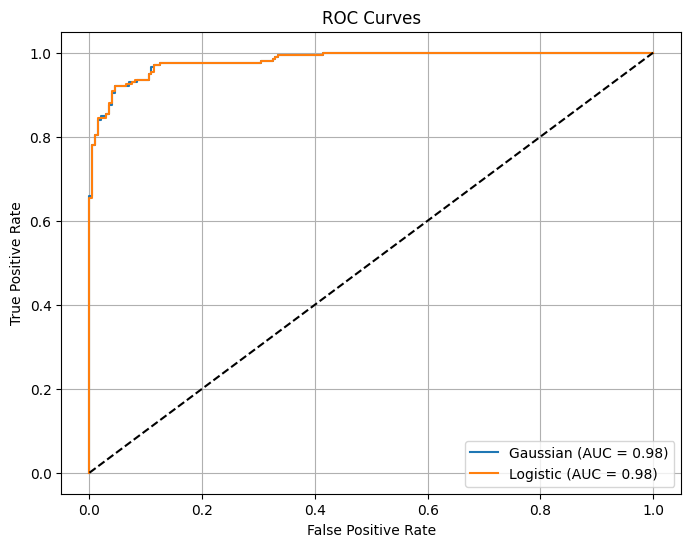

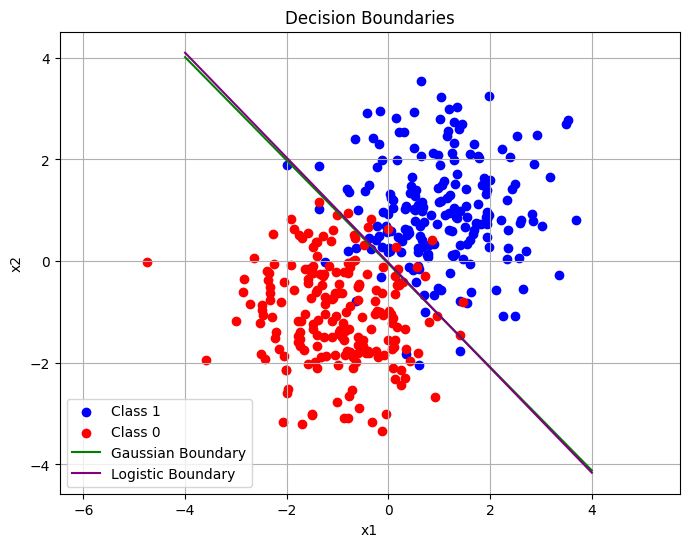

Gaussian Generative Accuracy: 93.25%
Logistic Regression Accuracy: 93.25%


In [30]:
from sklearn.metrics import accuracy_score, roc_curve, auc

# same dataset as before

# --- ROC Curve ---
fpr_g, tpr_g, _ = roc_curve(y_test, y_score_gauss)
fpr_l, tpr_l, _ = roc_curve(y_test, y_score_logistic)

plt.figure(figsize=(8, 6))
plt.plot(fpr_g, tpr_g, label=f'Gaussian (AUC = {auc(fpr_g, tpr_g):.2f})')
plt.plot(fpr_l, tpr_l, label=f'Logistic (AUC = {auc(fpr_l, tpr_l):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

# --- Decision Boundary Plot ---
def plot_decision_boundary(w, b, label, color):
    x_vals = np.linspace(-4, 4, 100)
    y_vals = -(w[0] * x_vals + b) / w[1]
    plt.plot(x_vals, y_vals, label=label, color=color)

plt.figure(figsize=(8, 6))
plt.scatter(X_test[y_test==1][:,0], X_test[y_test==1][:,1], c='blue', label='Class 1')
plt.scatter(X_test[y_test==0][:,0], X_test[y_test==0][:,1], c='red', label='Class 0')

# Gaussian boundary
plot_decision_boundary(w_gauss, b_gauss, 'Gaussian Boundary', 'green')

# Logistic boundary
w_l = w_irls[1:]
b_l = w_irls[0]
plot_decision_boundary(w_l, b_l, 'Logistic Boundary', 'purple')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision Boundaries')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# --- Accuracy Report ---
print(f"Gaussian Generative Accuracy: {acc_gauss * 100:.2f}%")
print(f"Logistic Regression Accuracy: {acc_logistic * 100:.2f}%")


# Online SHoppers Purchasieng Intention (binary classification w/ numeric features)

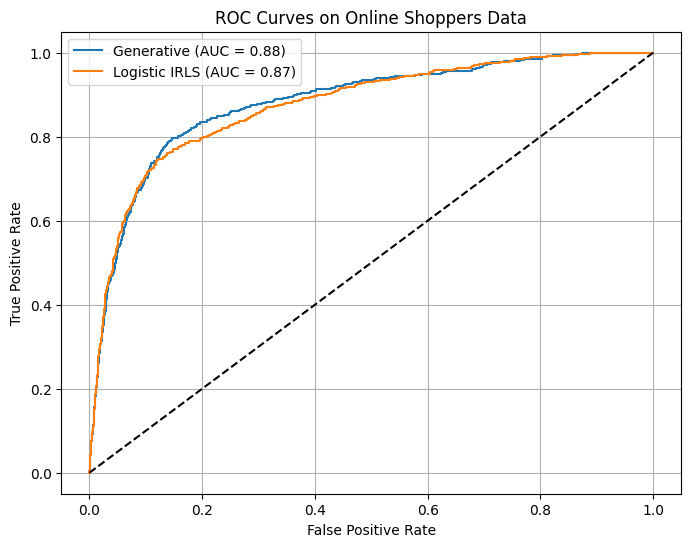

Generative Accuracy: 87.78% | AUC: 0.881
Logistic IRLS Accuracy: 87.10% | AUC: 0.875


In [31]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# Fetch dataset
data = fetch_ucirepo(id=468)
X_df = data.data.features
y = data.data.targets.to_numpy().ravel()

# Step 1: Keep only numeric columns
X_df_numeric = X_df.select_dtypes(include=[np.number])

# Step 2: Convert to NumPy and drop any rows with NaNs
X = X_df_numeric.to_numpy()
mask = ~np.isnan(X).any(axis=1)
X = X[mask]
y = y[mask]

# --- 2. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# --- 3. Gaussian Generative Model ---
mu1_hat = X_train[y_train == 1].mean(axis=0)
mu2_hat = X_train[y_train == 0].mean(axis=0)
sigma_hat = np.cov(X_train.T)
sigma_inv = np.linalg.inv(sigma_hat)

w_g = sigma_inv @ (mu1_hat - mu2_hat)
b_g = -0.5 * (mu1_hat.T @ sigma_inv @ mu1_hat - mu2_hat.T @ sigma_inv @ mu2_hat)

scores_g = X_test @ w_g + b_g
y_pred_g = (scores_g > 0).astype(int)
acc_g = accuracy_score(y_test, y_pred_g)
fpr_g, tpr_g, _ = roc_curve(y_test, scores_g)
auc_g = auc(fpr_g, tpr_g)

# --- 4. Logistic Regression via IRLS ---
def sigmoid(z): return 1 / (1 + np.exp(-z))

def IRLS(X, y, max_iter=100, tol=1e-6):
    Xb = np.hstack([np.ones((X.shape[0], 1)), X])
    w = np.zeros(Xb.shape[1])
    for _ in range(max_iter):
        z = Xb @ w
        y_hat = sigmoid(z)
        R = np.diag(y_hat * (1 - y_hat))
        H = Xb.T @ R @ Xb
        grad = Xb.T @ (y - y_hat)
        delta = np.linalg.inv(H) @ grad
        w += delta
        if np.linalg.norm(delta) < tol:
            break
    return w

w_l = IRLS(X_train, y_train)
Xb_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
scores_l = sigmoid(Xb_test @ w_l)
y_pred_l = (scores_l > 0.5).astype(int)
acc_l = accuracy_score(y_test, y_pred_l)
fpr_l, tpr_l, _ = roc_curve(y_test, scores_l)
auc_l = auc(fpr_l, tpr_l)

# --- 5. Plot ROC Curves ---
plt.figure(figsize=(8, 6))
plt.plot(fpr_g, tpr_g, label=f'Generative (AUC = {auc_g:.2f})')
plt.plot(fpr_l, tpr_l, label=f'Logistic IRLS (AUC = {auc_l:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on Online Shoppers Data')
plt.legend()
plt.grid(True)
plt.show()

# --- 6. Print Results ---
print(f"Generative Accuracy: {acc_g * 100:.2f}% | AUC: {auc_g:.3f}")
print(f"Logistic IRLS Accuracy: {acc_l * 100:.2f}% | AUC: {auc_l:.3f}")
